In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp

from decentr_constrained_huber import *
import ciropt as co

### Set the parameters for problem setup and generate random matrices and vectors

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 20
problem_spec['vector_size'] = 50
print(problem_spec)

problem_data = data_generation(problem_spec)
network_data = graph_generation(problem_spec['n_node'])
problem_data['itr_num'] = 2000

{'n_node': 20, 'vector_size': 50}


### Check the solution is different from unconstrained problem

In [3]:
f_star, x_opt_star = min_cvx_quad_constraint(problem_spec, problem_data, True)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

unconstrained_f_star, unconstrained_x_opt_star = min_cvx_quad_constraint(problem_spec, problem_data, False)
if (f_star, x_opt_star) == (unconstrained_f_star, unconstrained_x_opt_star):
    print("Constraints have no meaning")
else:
    print("Constraints have meaning")

f_star=84180.4497424232, np.linalg.norm(x_opt_star)=1099.0518913871897
Constraints have meaning


### Draw the network graph

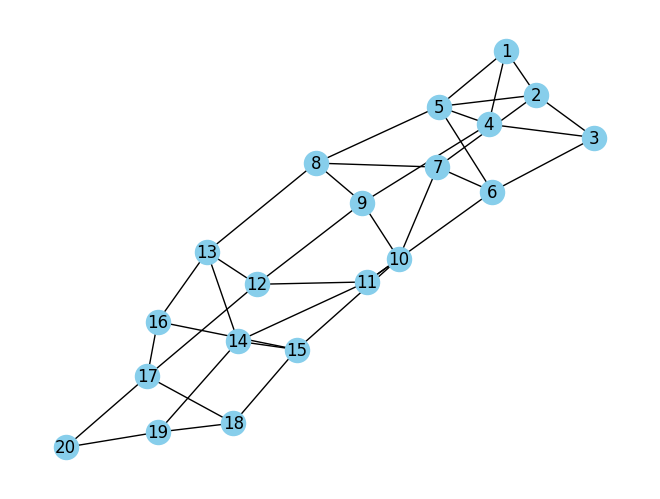

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n20.pdf")

### Define functions and proximal operators to implement the method

In [5]:
Q = problem_data['Q']
p = problem_data['p']
a = problem_data['a']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']

prox_operators = []
grad_h = []
f_plus_h = []

delta = 1

def huber_loss(a, b, delta):
    residual = a - b
    condition = np.abs(residual) <= delta
    squared_loss = 0.5 * np.square(residual)
    linear_loss = delta * (np.abs(residual) - 0.5 * delta)    
    return np.where(condition, squared_loss, linear_loss).sum()

for jj in range(n_node):
    Qj, pj, aj, bj = Q[jj], p[jj], a[jj], b[jj]
    prox_operators += [lambda z, rho, aj=aj, bj=bj : prox_fj_quad_constraint(z, rho, aj, bj) ]
    grad_h += [lambda z, Qj=Qj, pj=pj : grad_hj_quad_constraint(z, Qj, pj) ]
    f_plus_h += [lambda x_kj, Qj=Qj, pj=pj : huber_loss(x_kj, pj, delta) ]

### Find the best working parameters for PG-EXTRA with grid search

In [6]:
# apply PG-EXTRA 
# start, end, space = 0.01, 0.1, 0.005
# start, end, space = 0.1, 2, 0.1
# start, end, space = 0.1, 4, 0.1
start, end, space = 3.5, 5, 0.1
best_value = 100

for r in np.arange(start, end, space) :
    problem_data['rho'] = round(r, 2)
    pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                    network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                    grad_h=grad_h, f_plus_h=f_plus_h,
                                                                    printing=False, freq=200)
    # new_val = sum(pg_f_reldiff[300:400]) / 100
    new_val = sum(pg_f_reldiff[700:800]) / 100
    if new_val < best_value:
        print("new best_rho :", round(r, 2),  ", new best_value :", new_val)
        best_value = new_val
        best_rho = round(r, 2)
    

print("best_rho :", best_rho)

new best_rho : 3.5 , new best_value : 0.012665405501037941
new best_rho : 3.6 , new best_value : 0.01245946640193025
new best_rho : 3.7 , new best_value : 0.012193358876561285
new best_rho : 3.8 , new best_value : 0.01194852864374577
new best_rho : 3.9 , new best_value : 0.01184260256507534
new best_rho : 4.0 , new best_value : 0.011747480932025788
new best_rho : 4.3 , new best_value : 0.011722393782349549
best_rho : 4.3


#### Run PG-EXRA with the best working parameter

In [7]:
problem_data['rho'] = best_rho

pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.15690500781478411, err_opt_reldiff[-1]=0.9972007330010197
ii=200, f_reldiff[-1]=0.029936011812080998, err_opt_reldiff[-1]=0.7281712141753183
ii=400, f_reldiff[-1]=0.020413252421903543, err_opt_reldiff[-1]=0.6267689458760908
ii=600, f_reldiff[-1]=0.013793494938147237, err_opt_reldiff[-1]=0.5526394412938904
ii=800, f_reldiff[-1]=0.011231511387608046, err_opt_reldiff[-1]=0.50270780274225
ii=1000, f_reldiff[-1]=0.010180673872590822, err_opt_reldiff[-1]=0.46057879286703257
ii=1200, f_reldiff[-1]=0.008675731458720118, err_opt_reldiff[-1]=0.4249886208504563
ii=1400, f_reldiff[-1]=0.008101580781419851, err_opt_reldiff[-1]=0.3959562459678231
ii=1600, f_reldiff[-1]=0.007487679822978463, err_opt_reldiff[-1]=0.3705872092347999
ii=1800, f_reldiff[-1]=0.006958157127859498, err_opt_reldiff[-1]=0.35293520336609424
ii=1999, f_reldiff[-1]=0.00613395544237118, err_opt_reldiff[-1]=0.33823216119590566


### Run PG-EXTRA + Parallel C

In [30]:
# params={"R":1, "Capacitance":0, "h":0.5}  
# params={"R":0.7, "Capacitance":0.4, "h":0.8}  
# params={"R":4, "Capacitance":0.01, "h":1}
# params={"R":4.5, "Capacitance":0.5, "h":1.1}
params={"R":6, "Capacitance":0.6, "h":1.4}

pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_par_c", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.14680413604996775, err_opt_reldiff[-1]=0.9961982405720292
ii=200, f_reldiff[-1]=0.0299705392189708, err_opt_reldiff[-1]=0.6850526833781269
ii=400, f_reldiff[-1]=0.018021935749252455, err_opt_reldiff[-1]=0.5680548577460103
ii=600, f_reldiff[-1]=0.014081128006047902, err_opt_reldiff[-1]=0.4970943011880861
ii=800, f_reldiff[-1]=0.011842595335337004, err_opt_reldiff[-1]=0.44149176703763665
ii=1000, f_reldiff[-1]=0.011781990144776723, err_opt_reldiff[-1]=0.3985688862232464
ii=1200, f_reldiff[-1]=0.009683085345111305, err_opt_reldiff[-1]=0.3646576447974588
ii=1400, f_reldiff[-1]=0.008807446888470898, err_opt_reldiff[-1]=0.3385900710854765
ii=1600, f_reldiff[-1]=0.008492658725542803, err_opt_reldiff[-1]=0.3138885638299278
ii=1800, f_reldiff[-1]=0.008701733438896372, err_opt_reldiff[-1]=0.3025782884931475
ii=1999, f_reldiff[-1]=0.009179382322374294, err_opt_reldiff[-1]=0.2930938413178262


##### Running PG-EXTRA with same step size with PG-EXTRA + Parallel C

In [9]:
problem_data['rho'] = 0.7

pg_worse_op_norm, pg_worse_err_opt_star, pg_worse_err_opt_reldiff, pg_worse_const_vio, pg_worse_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.17829508919910092, err_opt_reldiff[-1]=0.9995179695732709
ii=200, f_reldiff[-1]=0.12749272820456822, err_opt_reldiff[-1]=0.9130470782799663
ii=400, f_reldiff[-1]=0.07735326283151975, err_opt_reldiff[-1]=0.8495969896477173
ii=600, f_reldiff[-1]=0.050885985774205784, err_opt_reldiff[-1]=0.8071226366209392
ii=800, f_reldiff[-1]=0.03921164770257627, err_opt_reldiff[-1]=0.776682972237631
ii=1000, f_reldiff[-1]=0.030953758711774224, err_opt_reldiff[-1]=0.7528747912687
ii=1200, f_reldiff[-1]=0.027872551196971577, err_opt_reldiff[-1]=0.733084536741989
ii=1400, f_reldiff[-1]=0.025543438768158875, err_opt_reldiff[-1]=0.7137156405745612
ii=1600, f_reldiff[-1]=0.023194163735171126, err_opt_reldiff[-1]=0.6954147324015723
ii=1800, f_reldiff[-1]=0.02083473797339504, err_opt_reldiff[-1]=0.6783028063184348
ii=1999, f_reldiff[-1]=0.018872635470197238, err_opt_reldiff[-1]=0.6624701875220269


## Plot the results

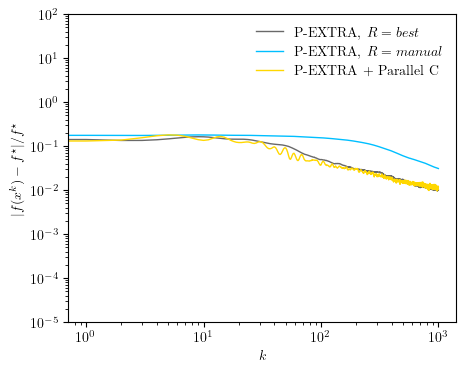

In [31]:
fname = "n20_circuit_pg_extra_par_c"

T = 1000
co.plot_methods([pg_f_reldiff[:T] ,pg_worse_f_reldiff[:T], pg_c_f_reldiff[:T]],
                ['P-EXTRA, $R=best$', 'P-EXTRA, $R=manual$', 'P-EXTRA + Parallel C'], 1e-5, 1e+2, fname)

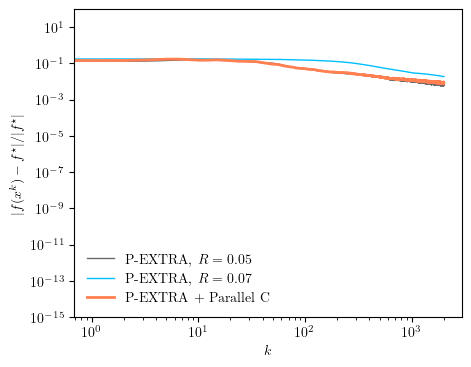

In [11]:
fname = "n20_qp_constraint_circuit_pg_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' 
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA, $R=0.05$', color=black, linewidth=1)
plt.plot(pg_worse_f_reldiff, label='P-EXTRA, $R=0.07$', color=blue, linewidth=1)
plt.plot(pg_c_f_reldiff, label='P-EXTRA + Parallel C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
plt.ylim(1e-15, 1e+2)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)

#### Check the first iteration where the error falls below a certain criterion for each method

In [12]:
criterion = 1e-8

print( np.where(np.array(pg_c_f_reldiff) < criterion)[0][0] )
print( np.where(np.array(pg_f_reldiff) < criterion)[0][0] )
print( np.where(np.array(pg_worse_f_reldiff) < criterion)[0][0] )

IndexError: index 0 is out of bounds for axis 0 with size 0